### Created on 2023
### @author: S.W

#### References
- https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d
- https://github.com/akshaysharma096/Siamese-Networks/blob/master/Few%20Shot%20Learning%20-%20V1.ipynb

------

## 1. 학습에 필요한 라이브러리 불러오기

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.datasets import mnist
import tensorflow_datasets as tfds

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### omniglot dataset
- https://github.com/brendenlake/omniglot
- https://www.tensorflow.org/datasets/catalog/omniglot?hl=ko

다양한 국가의 다양한 문자(Alphabet)에 대한 데이터 셋을 옴니글롯 데이터셋입니다. 옴니글롯 데이터셋은 다양한 알파벳에 속한 문자를 손으로 쓴 1623개의 고유한 글자 이미지를 포함하며, 각 글자에 대해 20개의 다른 사람이 쓴 예제입니다.<br>

옴니글롯 데이터셋은 다양한 알파벳에 속한 문자를 손으로 쓴 1623개의 고유한 글자 이미지를 포함하며, 각 글자에 대해 20개의 다른 사람이 쓴 예제가 있습니다.<br>


옴니글롯 데이터셋은 전체적으로 다음과 같이 구성되어 있습니다:<br>
- 총 데이터의 수: 32,460개의 이미지 (20개의 예제 x 1623개의 글자)
- 클래스 수: 1623개의 고유한 글자 (50개의 다른 알파벳)
- 이미지 크기: 105x105

In [2]:
import tensorflow_datasets as tfds

# Set the custom data directory
custom_data_dir = "./omniglot_datasets"

# Load the Omniglot dataset info with the custom data directory
dataset, info = tfds.load("omniglot", split="train", data_dir=custom_data_dir, with_info=True, as_supervised=True) # split=['train', 'test']

#### "ExtractError: Error while extracting " 에러가 나는 경우
#### Windows에서는 기본적으로 경로 길이가 260자를 초과하는 경우 오류가 발생

1. Windows에서 경로 길이 제한을 해제합니다.

- Windows 버전이 Windows 10 버전 1607 이상인 경우 경로 길이 제한을 해제할 수 있습니다. 먼저 'regedit'를 실행하여 레지스트리 편집기를 엽니다. 그런 다음 다음 레지스트리 키로 이동합니다: **HKEY_LOCAL_MACHINE/SYSTEM/CurrentControlSet/Control/FileSystem**

- 오른쪽 창에서 LongPathsEnabled이라는 항목을 찾아 더블 클릭합니다. 값 데이터를 1로 설정하고 '확인'을 클릭합니다. 변경 사항이 적용되려면 시스템을 다시 시작해야 할 수 있습니다.

In [3]:
# Dataset details
print(info)

tfds.core.DatasetInfo(
    name='omniglot',
    full_name='omniglot/3.0.0',
    description="""
    Omniglot data set for one-shot learning. This dataset contains 1623 different
    handwritten characters from 50 different alphabets.
    """,
    homepage='https://github.com/brendenlake/omniglot/',
    data_path='./omniglot_datasets\\omniglot\\3.0.0',
    download_size=17.95 MiB,
    dataset_size=12.29 MiB,
    features=FeaturesDict({
        'alphabet': ClassLabel(shape=(), dtype=tf.int64, num_classes=50),
        'alphabet_char_id': tf.int64,
        'image': Image(shape=(105, 105, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=1623),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'small1': <SplitInfo num_examples=2720, num_shards=1>,
        'small2': <SplitInfo num_examples=3120, num_shards=1>,
        'test': <SplitInfo num_examples=13180, num_shards=1>,
        'train': <SplitInfo num_examp

In [4]:
info.splits.keys(), info.splits['train'].num_examples, info.splits['test'].num_examples

(dict_keys(['train', 'test', 'small1', 'small2']), 19280, 13180)

## 2. 이미지 데이터 전처리

In [5]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (105, 105))
    return image, label

dataset = dataset.map(preprocess)

In [6]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing data
train_data, test_data = train_test_split(list(dataset), test_size=0.2)

len(train_data), len(test_data)

(15424, 3856)

#### 데이터 쌍을 만들고 데이터를 분할

In [7]:
def create_balanced_pairs(dataset, num_pairs=10000):
    images, labels = [], []
    for image, label in dataset.batch(1):
        images.append(image)
        labels.append(label)
        
    labels = np.array(labels)

    # Get the unique labels and store the indices for each label
    unique_labels, indices = np.unique(labels, return_inverse=True)
    label_indices = [np.where(indices == label)[0] for label in range(len(unique_labels))]

    pairs, targets = [], []
    for _ in range(num_pairs // 2):
        # Create a positive pair (same label)
        label = np.random.choice(len(unique_labels))
        idx1, idx2 = np.random.choice(label_indices[label], 2, replace=False)
        pairs += [[images[idx1], images[idx2]]]
        targets += [1]

        # Create a negative pair (different labels)
        label1, label2 = np.random.choice(len(unique_labels), 2, replace=False)
        idx1 = np.random.choice(label_indices[label1])
        idx2 = np.random.choice(label_indices[label2])
        pairs += [[images[idx1], images[idx2]]]
        targets += [0]

    pairs = np.array(pairs)
    targets = np.array(targets)

    return pairs, targets

pairs, targets = create_balanced_pairs(dataset)
train_pairs, test_pairs, train_targets, test_targets = train_test_split(pairs, targets, test_size=0.2)


In [8]:
train_pairs.shape, test_pairs.shape, train_targets.shape, test_targets.shape

((8000, 2, 1, 105, 105, 3), (2000, 2, 1, 105, 105, 3), (8000,), (2000,))

#### 데이터 확인하기

In [9]:
np.unique(train_targets), np.unique(test_targets)

(array([0, 1]), array([0, 1]))

In [10]:
# Count the number of 0's and 1's
count_zeros = np.count_nonzero(train_targets == 0)
count_ones = np.count_nonzero(train_targets == 1)

print("Number of 0's:", count_zeros)
print("Number of 1's:", count_ones)

Number of 0's: 3982
Number of 1's: 4018


In [11]:
# Count the number of 0's and 1's
count_zeros = np.count_nonzero(test_targets == 0)
count_ones = np.count_nonzero(test_targets == 1)

print("Number of 0's:", count_zeros)
print("Number of 1's:", count_ones)

Number of 0's: 1018
Number of 1's: 982


## 3. 샴 네트워크(Siamese neural network) 구성

In [12]:
def create_siamese_network(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(64, (10, 10), activation='relu')(input)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (7, 7), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (4, 4), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(256, (4, 4), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(4096, activation='sigmoid')(x)
    return Model(input, x)

input_shape = (105, 105, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

siamese_network = create_siamese_network(input_shape)

encoded_l = siamese_network(left_input)
encoded_r = siamese_network(right_input)

L1_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])

prediction = Dense(1, activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

In [13]:
optimizer = Adam()
siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## 4. 모델 학습

In [14]:
train_left, train_right = train_pairs[:, 0].reshape(-1, 105, 105, 3), train_pairs[:, 1].reshape(-1, 105, 105, 3)
test_left, test_right = test_pairs[:, 0].reshape(-1, 105, 105, 3), test_pairs[:, 1].reshape(-1, 105, 105, 3)

In [15]:
history = siamese_net.fit([train_left, train_right], train_targets,
                          batch_size=128,
                          epochs=10,
                          validation_data=([test_left, test_right], test_targets))

Epoch 1/10
63/63 [==============================] - 17s 191ms/step - loss: 0.5868 - accuracy: 0.6568 - val_loss: 0.5174 - val_accuracy: 0.7220
Epoch 2/10
63/63 [==============================] - 9s 139ms/step - loss: 0.4592 - accuracy: 0.7875 - val_loss: 0.4188 - val_accuracy: 0.8210
Epoch 3/10
63/63 [==============================] - 9s 139ms/step - loss: 0.3322 - accuracy: 0.8579 - val_loss: 0.3595 - val_accuracy: 0.8435
Epoch 4/10
63/63 [==============================] - 9s 139ms/step - loss: 0.2228 - accuracy: 0.9141 - val_loss: 0.3395 - val_accuracy: 0.8595
Epoch 5/10
63/63 [==============================] - 9s 141ms/step - loss: 0.1090 - accuracy: 0.9615 - val_loss: 0.3635 - val_accuracy: 0.8590
Epoch 6/10
63/63 [==============================] - 9s 141ms/step - loss: 0.0525 - accuracy: 0.9851 - val_loss: 0.3498 - val_accuracy: 0.8645
Epoch 7/10
63/63 [==============================] - 9s 140ms/step - loss: 0.0292 - accuracy: 0.9924 - val_loss: 0.3457 - val_accuracy: 0.8840
Epoch

#### 학습 과정 시각화

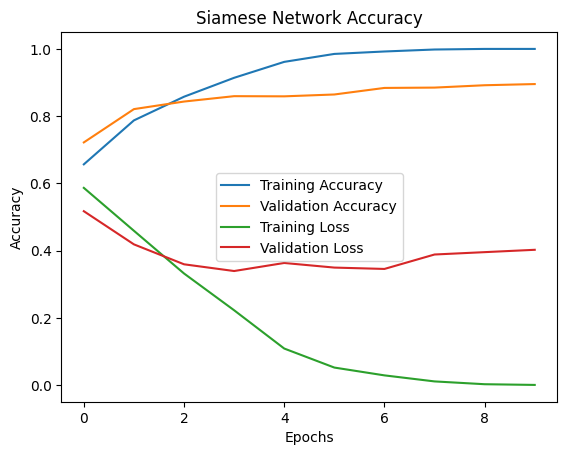

In [16]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Siamese Network Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 5. 모델 평가

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

predictions = siamese_net.predict([test_left, test_right])
binary_predictions = (predictions > 0.5).astype(int)

accuracy = accuracy_score(test_targets, binary_predictions)
precision = precision_score(test_targets, binary_predictions)
recall = recall_score(test_targets, binary_predictions)
f1 = f1_score(test_targets, binary_predictions)

print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 0.90
Precision: 0.89
Recall: 0.90
F1 Score: 0.89


In [18]:
cm = confusion_matrix(test_targets, binary_predictions)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[903 115]
 [ 94 888]]
